# Desafio Semana 8 : Enem 2


**Descubra as melhores notas de matemática do ENEM 2016** <br>
Você deverá criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016.
<br>
Para isso, usará Python, Pandas, Sklearn e Regression.<br>
<br>
**Detalhes**
<br>
O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o Dicionário dos Microdados do Enem 2016.<br>
<br>
No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna NU_NOTA_MT) de quem participou do ENEM 2016.<br>
<br>
Salve sua resposta em um arquivo chamado answer.csv com duas colunas: NU_INSCRICAO e NU_NOTA_MT.<br>


**Variável Alvo:** NU_NOTA_MT

##**Análise Exploratória**

In [1]:
# Importação das bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#biblioteca de pré-processamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#biblioteca de featuring engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Importando arquivos de dados:
df_test = pd.read_csv('/content/drive/My Drive/enem-2/test.csv')
df_train = pd.read_csv('/content/drive/My Drive/enem-2/train.csv')

In [4]:
# Realizando cópia dos df
df_test_orig = df_test.copy()
df_train_orig = df_train.copy()

In [5]:
# Verificando o tamanho dos datasets:
df_train.shape, df_test.shape

((13730, 167), (4576, 47))

Observa-se diferença no número de colunas entre os dados de treino e teste. 

In [6]:
# Verificar se os dados de teste estão inclusos no dataset de treino
print(set(df_test.columns).issubset(set(df_train.columns)))

True


In [7]:
# Selecionando as colunas presentes no df_treino + variável alvo
columns_selected = list(df_test.columns)
columns_selected.append('NU_NOTA_MT')
#columns_selected

In [8]:
# Aplicando a seleção das colunas no df de treino
df_train = df_train[columns_selected]

In [9]:
# Verificando as colunas no dataset de treino
df_train.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'NU_NOTA_MT'],
      dtype='object')

De acordo com o dicionário de dados e colunas acima, observam-se que existem variáveis que representam códigos que não apresentam nenhuma relevância ao modelo. Portanto, serão removidas dos datasets.

In [10]:
codigos = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT']
df_train = df_train.drop(codigos, axis=1)
df_test = df_test.drop(codigos, axis=1)

In [11]:
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - TRAIN DATA')
aux = pd.DataFrame({'column': df_train.columns,
                    'dtype': df_train.dtypes,
                    'missing': df_train.isna().sum(),
                    'size': df_train.shape[0],
                    'unique': df_train.nunique(),
                    'missing_perc': ((df_train.isna().sum() / df_train.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - TRAIN DATA


,column,dtype,missing,size,unique,missing_perc
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,68.81
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,68.81
Q027,Q027,object,7373,13730,13,53.70
NU_NOTA_MT,NU_NOTA_MT,float64,3597,13730,3406,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,3597,13730,2774,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,3597,13730,15,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,26.20


In [12]:
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - Test Data')
aux = pd.DataFrame({'column': df_test.columns,
                    'dtype': df_test.dtypes,
                    'missing': df_test.isna().sum(),
                    'size': df_test.shape[0],
                    'unique': df_test.nunique(),
                    'missing_perc': ((df_test.isna().sum() / df_test.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)


Creating DataFrame for Data Manipulation - Test Data


,column,dtype,missing,size,unique,missing_perc
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,3096,4576,4,67.66
TP_ENSINO,TP_ENSINO,float64,3096,4576,3,67.66
Q027,Q027,object,2488,4576,13,54.37
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,1199,4576,11,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,1199,4576,1839,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,1199,4576,9,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,1199,4576,10,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,1199,4576,10,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,1199,4576,11,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,1199,4576,44,26.20


As features IN_CEGUEIRA, IN_DISLEXIA, IN_DISCALCULIA apresentam apenas 1 valor único no dataset de teste, portanto não tem variância e não são relevantes para o modelo. Serão removidas no df_treino e df_test.

In [13]:
feat_unique = ['IN_CEGUEIRA', 'IN_DISLEXIA', 'IN_DISCALCULIA']
df_train = df_train.drop(feat_unique, axis=1)
df_test = df_test.drop(feat_unique, axis=1)

## **Exploração dos dados**

In [14]:
# Verificando todas as correlações com a variável alvo:
cor = pd.DataFrame(df_train.corr().NU_NOTA_MT)
cor['missing_perc'] = ((df_train.isna().sum() / df_train.shape[0]) * 100).round(2)
cor.sort_values('NU_NOTA_MT', ascending=False)

,NU_NOTA_MT,missing_perc
NU_NOTA_MT,1.00,26.20
NU_NOTA_CN,0.58,24.68
NU_NOTA_CH,0.53,24.68
NU_NOTA_LC,0.49,26.20
NU_NOTA_REDACAO,0.38,26.20
TP_DEPENDENCIA_ADM_ESC,0.37,68.81
NU_NOTA_COMP3,0.35,26.20
NU_NOTA_COMP5,0.34,26.20
NU_NOTA_COMP4,0.34,26.20
NU_NOTA_COMP2,0.34,26.20


A feature TP_DEPENDENCIA_ADM_ESC apesar de apresentar correlação de 0.37 com a variável alvo possui	68.81% de dados faltantest. Portanto, irei remover a feature dos datasets.

In [15]:
df_train = df_train.drop(['TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], axis=1)
df_test = df_test.drop(['TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], axis=1)

A feature TP_PRESENCA_LC apresentou NaN na correlação com a variável alvo. Segundo o dicionário de dados, essa feature representa a presença do aluno na prova de Linguagens e Códigos (LC). Além disso, outra informação relevante é de que a prova de LC é realizada no mesmo dia da prova de Matemática e Tecnologia (MT), portanto, podemos inferir que a ausência na prova de LC é igual a ausência na prova de MT.

In [16]:
df_train['TP_PRESENCA_LC'].value_counts()

1    10133
0     3592
2        5
Name: TP_PRESENCA_LC, dtype: int64

In [17]:
df_test['TP_PRESENCA_LC'].value_counts()

1    3377
0    1195
2       4
Name: TP_PRESENCA_LC, dtype: int64

Observa-se que nos dados de teste 1195 candidatos não compareceram a prova de LC e, por consequencia, não terão nota na prova de MT. O que pode ser uma grande fonte de ruído. 

In [18]:
# Separando as colunas não-numéricas
df_train_cat = df_train.select_dtypes(exclude='number')
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - Treino Categóricas')
aux = pd.DataFrame({'column': df_train_cat.columns,
                    'dtype': df_train_cat.dtypes,
                    'missing': df_train_cat.isna().sum(),
                    'size': df_train_cat.shape[0],
                    'unique': df_train_cat.nunique(),
                    'missing_perc': ((df_train_cat.isna().sum() / df_train_cat.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - Treino Categóricas


,column,dtype,missing,size,unique,missing_perc
Q027,Q027,object,7373,13730,13,53.70
NU_INSCRICAO,NU_INSCRICAO,object,0,13730,13730,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
Q001,Q001,object,0,13730,8,0.00
Q002,Q002,object,0,13730,8,0.00
Q006,Q006,object,0,13730,17,0.00
Q024,Q024,object,0,13730,5,0.00
Q025,Q025,object,0,13730,2,0.00
Q026,Q026,object,0,13730,3,0.00


In [19]:
# Separando as colunas numéricas
df_train_num = df_train.select_dtypes(include='number')
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - Treino Numéricas')
aux = pd.DataFrame({'column': df_train_num.columns,
                    'dtype': df_train_num.dtypes,
                    'missing': df_train_num.isna().sum(),
                    'size': df_train_num.shape[0],
                    'unique': df_train_num.nunique(),
                    'missing_perc': ((df_train_num.isna().sum() / df_train_num.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - Treino Numéricas


,column,dtype,missing,size,unique,missing_perc
NU_NOTA_MT,NU_NOTA_MT,float64,3597,13730,3406,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,3597,13730,53,26.20
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,3597,13730,14,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,3597,13730,15,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,3597,13730,2774,26.20
NU_NOTA_CH,NU_NOTA_CH,float64,3389,13730,2978,24.68


Histograma dataset de treino


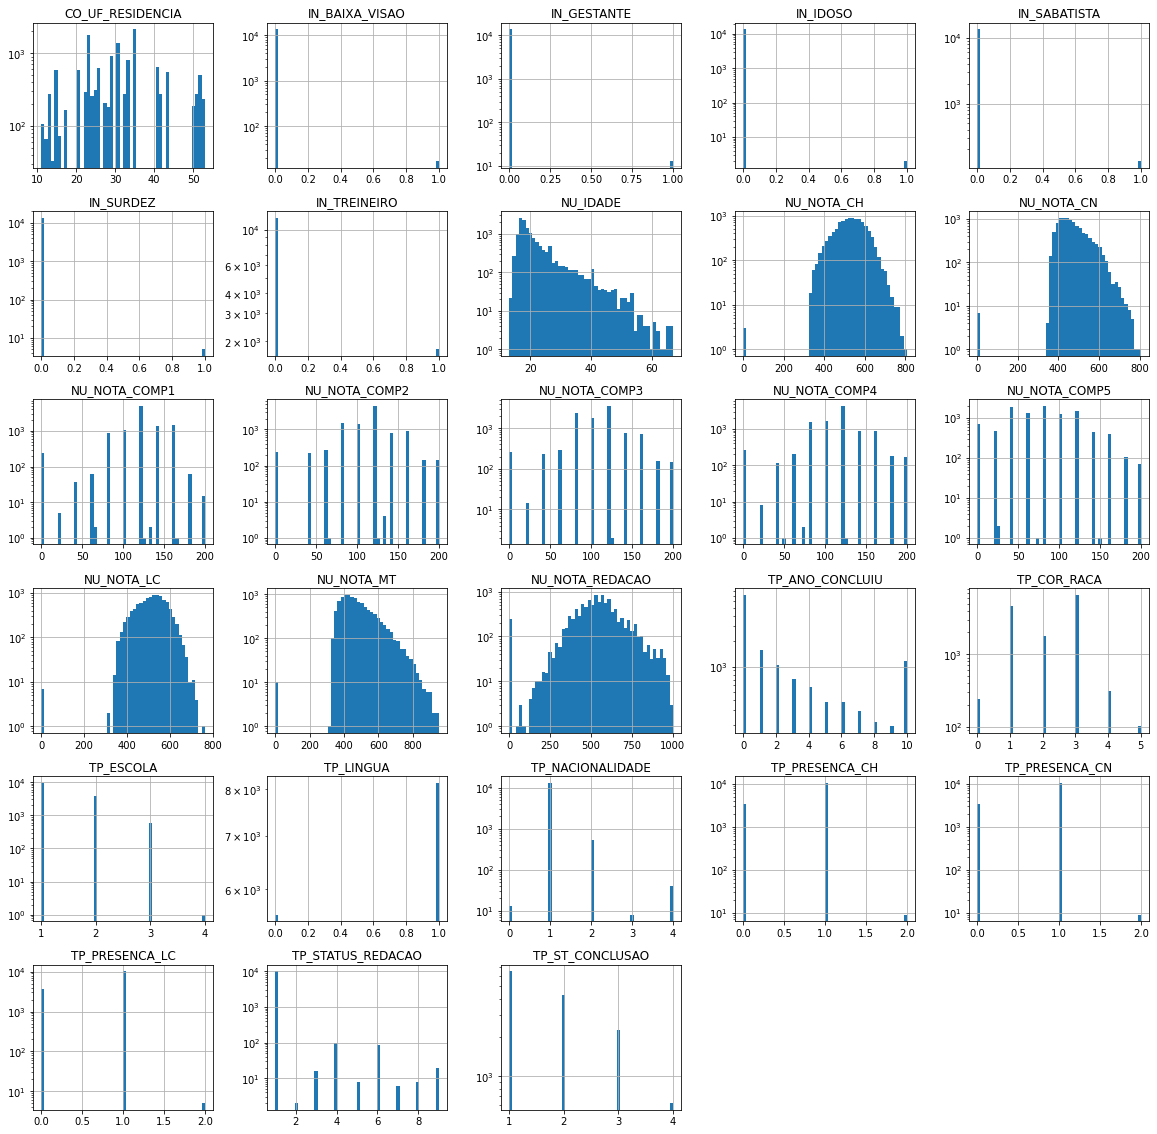

In [20]:
# Explorando a distribuição das variáveis numéricas
df_train_num.hist(bins=50,log=True, figsize=(20, 20))
print('Histograma dataset de treino')
plt.show()

## Estratégia 1 para substituir os nulos: completar com zeros

In [21]:
# Criando uma lista de colunas categóricas e numericas
list_cat = list(df_train_cat.columns)
list_num = list(df_train_num.columns)

In [22]:
df_train[list_cat] = df_train[list_cat].fillna('0')
df_train[list_num] = df_train[list_num].fillna(0)


In [23]:
df_train = df_train.set_index('NU_INSCRICAO')
#df_train.info()

## Criando variáveis para treinar o modelo

In [24]:
# Criando variáveis explicativas (X) e dependente (Y).
X = df_train.drop('NU_NOTA_MT', axis=1)
y = df_train['NU_NOTA_MT']

### **Pré-processamento dos dados**

In [25]:
X.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,0,0,0,0,0,0,1,1,1,436.30,495.40,581.20,1,1.00,120.00,120.00,120.00,80.00,80.00,520.00,D,D,C,A,A,C,H,A
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,0,0,0,0,0,0,1,1,1,474.50,544.10,599.00,1,1.00,140.00,120.00,120.00,120.00,80.00,580.00,A,A,B,A,A,A,0,A
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,D,D,C,A,A,A,0,A
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,H,E,E,C,B,C,F,D
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,E,D,C,A,A,B,F,A


In [26]:
# Selecionando os pré-processadores
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

In [27]:
# Aplicando o pré-processamento
for coluna in X.columns[1:]:
  try:
    X[coluna] = encoder.fit_transform(X[[coluna]])
    X[coluna] = scaler.fit_transform(X[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

In [28]:
X.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,-0.07,-0.01,-1.27,-0.13,-0.03,1.05,-1.05,0.67,0.39,0.04,0.02,0.10,0.03,0.01,-0.57,-0.57,-0.60,-0.57,-0.57,-0.60,-0.83,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.27,-0.22,-0.19,1.12,1.15,-1.05,-1.08,0.41
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,-0.07,-0.01,0.79,-0.13,-0.03,-0.95,0.95,-1.49,0.39,0.04,0.02,0.10,0.03,0.01,-0.57,-0.57,-0.60,-0.57,-0.57,-0.60,-0.83,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,3.70,4.51,-0.19,1.12,1.15,0.95,0.93,0.41
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,-0.07,-0.01,0.79,-0.13,-0.03,-0.95,0.95,0.67,0.39,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,-0.83,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,1.12,1.15,0.95,0.93,0.41
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,-0.07,-0.01,0.79,7.48,-0.03,1.05,-1.05,0.67,0.39,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,1.21,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,-0.90,-0.87,-1.05,-1.08,-2.42
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,-0.07,-0.01,-1.27,-0.13,-0.03,1.05,-1.05,0.67,0.39,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,-0.83,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,1.12,1.15,-1.05,-1.08,0.41


### **Featuring Engineering**

In [29]:
# Aplicando o PCA (Principal component analysis)
pca = PCA(0.95).fit(X)
pca.n_components_

15

In [30]:
# Criando estimador para aplicar o RFE 
estimator = LinearRegression()
rfe = RFE(estimator, 15, step=1)

In [31]:
# Seleção de features usando o RFE
rfe.fit(X, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=15, step=1, verbose=0)

In [32]:
colunas_teste = pd.DataFrame({'column':X.columns,
              'selection': rfe.support_})

In [33]:
colunas_selecionadas = colunas_teste.loc[colunas_teste['selection'] == True]
lista_features = list(colunas_selecionadas.column.values)
lista_features.append('TP_PRESENCA_LC')
lista_features

['TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q024',
 'Q047',
 'TP_PRESENCA_LC']

## **Aplicando o modelo**

### **Usando todas as features**

In [34]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X,y, random_state = 1606 )
print(x_treino.shape)
print(x_teste.shape)
print(y_treino.shape)
print(y_teste.shape)

(10297, 37)
(3433, 37)
(10297,)
(3433,)


In [35]:
#testando uma linear regression simples com todas as features
modelo = LinearRegression()
modelo.fit(x_treino, y_treino)
predicoes_modelo = abs(modelo.predict(x_teste))

In [36]:
from sklearn.metrics import mean_squared_error
avaliacao = mean_squared_error(y_teste, predicoes_modelo)
print(f"Minha avaliação nos dados de teste foi de {avaliacao}")
print(modelo.score(x_teste, y_teste) * 100)

Minha avaliação nos dados de teste foi de 6056.118889836365
88.193923560283


In [37]:
#Exemplo de classificação com Dummy
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

modelo_dummy = DummyRegressor()
modelo_dummy.fit(x_treino, y_treino)
dummy_predicoes = modelo_dummy.predict(x_teste)

avaliacao_dummy = mean_squared_error(y_teste, dummy_predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao_dummy}")


Minha avaliação nos dados de teste foi de 51302.73268362567


## **Apenas com features selecionadas**

In [38]:
#redefinindo o X Treino e teste usando o X só com as colunas de teste
X = X[lista_features]

x_treino, x_teste, y_treino, y_teste = train_test_split(X,y, random_state = 1606 )
#devolve x_treino, x_teste, y_treino e y_teste
print(x_treino.shape)
print(x_teste.shape)
print(y_treino.shape)
print(y_teste.shape)

(10297, 16)
(3433, 16)
(10297,)
(3433,)


In [39]:
modelo.fit(x_treino,y_treino)
predicoes_modelo = abs(modelo.predict(x_teste))
avaliacao = mean_squared_error(y_teste, predicoes_modelo)
print(f"Minha avaliação nos dados de teste foi de {avaliacao}")
print(modelo.score(x_teste, y_teste) * 100)

Minha avaliação nos dados de teste foi de 6093.800820672411
88.12046467284385


## **Testando com GradientBoostingRegressor**

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
modelo21 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo21.fit(x_treino, y_treino)
predicoes_modelo = modelo21.predict(x_teste)
avaliacao = mean_squared_error(y_teste, predicoes_modelo)
print(f"Minha avaliação nos dados de teste foi de {avaliacao}")
print(modelo21.score(x_teste, y_teste) * 100)

Minha avaliação nos dados de teste foi de 5734.020632311533
88.82183670376828


In [41]:
#Testando com o modelo campeão com a análise anterior
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
modelo = HistGradientBoostingRegressor(random_state=0, learning_rate=0.1, max_iter=1000)
modelo.fit(x_treino, y_treino)
predicoes_modelo= modelo.predict(x_teste)
avaliacao = mean_squared_error(y_teste, predicoes_modelo)
print(f"Minha avaliação nos dados de teste foi de {avaliacao}")
print(modelo.score(x_teste, y_teste) * 100)

Minha avaliação nos dados de teste foi de 5851.941933261
88.59195550126802


## **usando o StatsModels para definir quão bem as features explicam o problema**

In [42]:
from statsmodels.api import add_constant
x = add_constant(X)
y = y

In [43]:
regressao = sm.OLS(y,x).fit()
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     8063.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:02:38   Log-Likelihood:                -79272.
No. Observations:               13730   AIC:                         1.586e+05
Df Residuals:                   13716   BIC:                         1.587e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               356.0926      0.66

In [44]:
# Mantendo apenas features significativas
feat_sig = ['TP_SEXO','NU_NOTA_LC', 'TP_LINGUA', 'NU_NOTA_COMP5', 'Q024', 'Q047', 'TP_PRESENCA_LC' ]

In [45]:
x_selected = x[feat_sig]

In [46]:
regressao2 = sm.OLS(y, x_selected).fit()
print(regressao2.summary())

                                 OLS Regression Results                                
Dep. Variable:             NU_NOTA_MT   R-squared (uncentered):                   0.258
Model:                            OLS   Adj. R-squared (uncentered):              0.258
Method:                 Least Squares   F-statistic:                              682.8
Date:                Mon, 31 Aug 2020   Prob (F-statistic):                        0.00
Time:                        19:02:38   Log-Likelihood:                     -1.0047e+05
No. Observations:               13730   AIC:                                  2.010e+05
Df Residuals:                   13723   BIC:                                  2.010e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [47]:
y_previsto = abs(regressao.predict(x))
residuo = regressao.resid


Text(0.5, 0, 'Y_previsto')

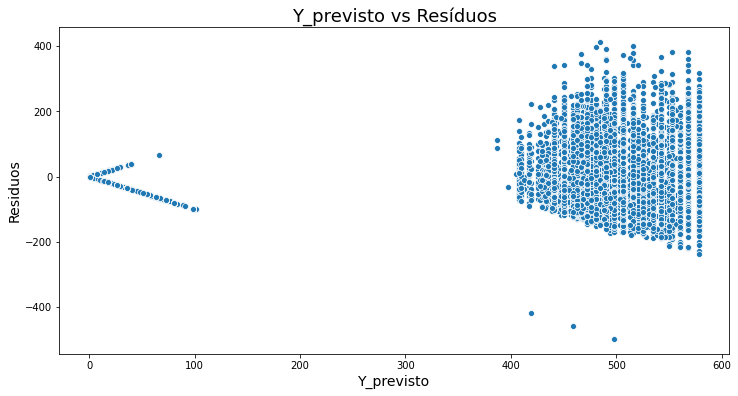

In [48]:
ax = sns.scatterplot(y=residuo, x=y_previsto)
ax.figure.set_size_inches(12,6)
ax.set_title('Y_previsto vs Resíduos', fontsize=18)
ax.set_ylabel('Residuos', fontsize=14)
ax.set_xlabel('Y_previsto', fontsize=14)

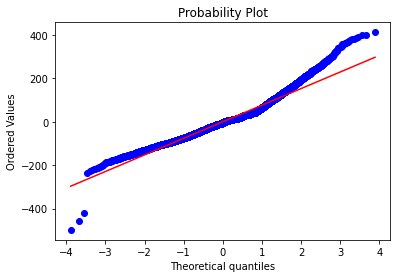

In [49]:
from scipy.stats import probplot
#visualizando a curva dos resíduos
(_,(_,_,_)) = probplot(residuo, plot = plt)

In [50]:
#calculando o MSE com o sm
#calculando com o Statsmodels
EQM = regressao.mse_resid
EQM

6065.43

### Após nova definição de colunas - reaplicaremos os testes do SKLearn¶


In [51]:
x_selected.head()

,TP_SEXO,NU_NOTA_LC,TP_LINGUA,NU_NOTA_COMP5,Q024,Q047,TP_PRESENCA_LC
NU_INSCRICAO,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,-1.27,-0.60,-0.83,-0.67,1.12,0.41,-0.60
2c3acac4b33ec2b195d77e7c04a2d75727fad723,0.79,-0.60,-0.83,-0.67,1.12,0.41,-0.60
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.79,1.68,-0.83,1.48,1.12,0.41,1.68
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.79,1.68,1.21,1.48,-0.90,-2.42,1.68
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,-1.27,1.68,-0.83,1.48,1.12,0.41,1.68


In [52]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_selected,y, random_state = 1606 )


In [53]:
from sklearn.ensemble import GradientBoostingRegressor
modelo21 = GradientBoostingRegressor(alpha=0.05, learning_rate=0.1, n_estimators=150, random_state=0)
modelo21.fit(x_treino, y_treino)
predicoes_modelo = modelo21.predict(x_teste)

In [54]:
print(f"Minha avaliação nos dados de teste foi de {avaliacao}")
print(modelo21.score(x_teste, y_teste) * 100)
print(predicoes_modelo[:5].round(1))
print(y_teste[:5])

Minha avaliação nos dados de teste foi de 5851.941933261
88.74382260792657
[ 4.409e+02  4.409e+02  4.885e+02  5.772e+02 -2.000e-01]
NU_INSCRICAO
4d90a1910ffb39e02fbf66176fe103c7cbcfa327   449.20
00e3220ed4a0f76a9076d28531cdfae81a3774b0   457.80
31daf51980849caf320172b2d9e83966d93c92e8   445.50
0352cb6307d663f5fb4f4acccd4ccef576e52c5e   506.80
458c445693310dfd5c0ccec83a70054b6b5521ed     0.00
Name: NU_NOTA_MT, dtype: float64


In [55]:
from sklearn.ensemble import RandomForestRegressor

# Criação do modelo:
regressor1 = RandomForestRegressor()

# Treinamento do modelo:
regressor1.fit(x_treino, y_treino)

# Previsões com a amostra de 10% do dataset de treino (dados novos):
y_pred_test1 = regressor1.predict(x_teste)
# Previsões com os dados que o modelo usou para treinamento:
y_pred_train1 = regressor1.predict(x_treino)

In [56]:

print("Avaliação com dados novos - diferentes do que o modelo viu no treinamento:")

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_teste, y_pred_test1).round(4)  )
print('MSE:', metrics.mean_squared_error(y_teste, y_pred_test1).round(4) ) 

from sklearn.metrics import r2_score
print('R²: {}'.format(round(r2_score(y_teste, y_pred_test1),4)))

from sklearn.model_selection import cross_val_score
print("Cross Validation: {}\n".format(round(cross_val_score(regressor1, x_teste, y_teste).mean(),2)))

print("Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:")

print('MAE:', metrics.mean_absolute_error(y_treino, y_pred_train1).round(4)  )
print('MSE:', metrics.mean_squared_error(y_treino, y_pred_train1).round(4) ) 

print('R²: {}'.format(round(r2_score(y_treino, y_pred_train1),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor1, x_treino, y_treino).mean(),2)))

Avaliação com dados novos - diferentes do que o modelo viu no treinamento:
MAE: 52.2903
MSE: 5812.4264
R²: 0.8867
Cross Validation: 0.89

Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:
MAE: 50.7253
MSE: 5672.2018
R²: 0.8924
Cross Validation: 0.89



# Predição dados teste

In [57]:
df_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,0,0,0,0,0,0,1,1,1,464.80,443.50,431.80,0,1.00,120.00,80.00,80.00,100.00,40.00,420.00,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,0,0,0,0,0,0,1,1,1,391.10,491.10,548.00,1,1.00,120.00,120.00,120.00,120.00,100.00,580.00,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,0,0,0,0,0,0,1,1,1,595.90,622.70,613.60,0,1.00,80.00,40.00,40.00,80.00,80.00,320.00,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,0,0,0,0,0,0,0,0,0,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,0,0,0,0,0,0,1,1,1,592.90,492.60,571.40,1,1.00,100.00,80.00,60.00,80.00,0.00,320.00,D,H,H,C,B,A,NaN,A


In [58]:
df_test_cat = df_test.select_dtypes(exclude='number')
df_test_num = df_test.select_dtypes(include='number')

In [59]:
# Criando uma lista de colunas categóricas e numericas
list_cat1 = list(df_test_cat.columns)
list_num1 = list(df_test_num.columns)

In [60]:
df_test[list_cat1] = df_test[list_cat1].fillna('0')
df_test[list_num1] = df_test[list_num1].fillna(0)

In [61]:
df_test = df_test.set_index('NU_INSCRICAO')

In [62]:
# Selecionando os pré-processadores
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()
# Aplicando o pré-processamento
for coluna in df_test.columns[1:]:
  try:
    df_test[coluna] = encoder.fit_transform(df_test[[coluna]])
    df_test[coluna] = scaler.fit_transform(df_test[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')


In [63]:
df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.38,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,4.51,-0.21,1.11,1.17,-1.07,-1.09,0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.38,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,-1.07,-1.09,0.41
b38a03232f43b11c9d0788abaf060f7366053b6d,23,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,0.38,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.38,0.03,0.01,0.10,0.02,0.00,1.74,1.74,1.68,1.74,1.74,1.68,1.24,1.68,1.61,1.61,1.61,1.61,1.49,1.61,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
715494628a50142ce8cb17191cfe6d0f3cae0934,41,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,0.38,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,1.49,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41


In [64]:
df_test_selected = df_test[feat_sig]
predictions = regressor1.predict(df_test_selected)


In [65]:
# Computar a resposta do dataframe df_resposta1
df_resposta = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predictions})

In [66]:
df_resposta.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,443.14
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,460.59
2,b38a03232f43b11c9d0788abaf060f7366053b6d,524.87
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.00
4,715494628a50142ce8cb17191cfe6d0f3cae0934,451.74


In [67]:
resposta = df_resposta.set_index("NU_INSCRICAO")

In [68]:
resposta.to_csv("/content/drive/My Drive/enem-2/answer.csv")